##**3. Word2Vec**
1. 주어진 단어들을 word2vec 모델에 들어갈 수 있는 형태로 만듭니다.
2. CBOW, Skip-gram 모델을 각각 구현합니다.
3. 모델을 실제로 학습해보고 결과를 확인합니다.
4. 산점도를 그려 단어들의 대략적인 위치를 확인해봅니다

### **필요 패키지 import**

In [43]:

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [44]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
from tqdm import tqdm
from konlpy.tag import Mecab,Twitter,Okt,Kkma
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

import torch
import copy
import numpy as np

### **데이터 전처리**



데이터를 확인하고 Word2Vec 형식에 맞게 전처리합니다.  

In [46]:
train_data = [
  "정말 맛있습니다. 추천합니다.",
  "기대했던 것보단 별로였네요.",
  "다 좋은데 가격이 너무 비싸서 다시 가고 싶다는 생각이 안 드네요.",
  "완전 최고입니다! 재방문 의사 있습니다.",
  "음식도 서비스도 다 만족스러웠습니다.",
  "위생 상태가 좀 별로였습니다. 좀 더 개선되기를 바랍니다.",
  "맛도 좋았고 직원분들 서비스도 너무 친절했습니다.",
  "기념일에 방문했는데 음식도 분위기도 서비스도 다 좋았습니다.",
  "전반적으로 음식이 너무 짰습니다. 저는 별로였네요.",
  "위생에 조금 더 신경 썼으면 좋겠습니다. 조금 불쾌했습니다."       
]

test_words = ["음식", "맛", "서비스", "위생", "가격"]

Tokenization과 vocab을 만드는 과정은 이전 실습과 유사합니다.

In [47]:
tokenizer = Okt()

In [48]:
def make_tokenized(data):
  tokenized = []
  for sent in tqdm(data): #문장들을 하나씩 뽑아서
    tokens = tokenizer.morphs(sent, stem=True) #토큰화
    tokenized.append(tokens)

  return tokenized

In [49]:
train_tokenized = make_tokenized(train_data)  #문장별로 토큰화된 리스트. # train_tokenized는 2차원 리스트.

100%|██████████| 10/10 [00:00<00:00, 240.88it/s]


In [50]:
print(train_tokenized[:10])


[['정말', '맛있다', '.', '추천', '하다', '.'], ['기대하다', '것', '보단', '별로', '이다', '.'], ['다', '좋다', '가격', '이', '너무', '비싸다', '다시', '가다', '싶다', '생각', '이', '안', '드네', '요', '.'], ['완전', '최고', '이다', '!', '재', '방문', '의사', '있다', '.'], ['음식', '도', '서비스', '도', '다', '만족스럽다', '.'], ['위생', '상태', '가', '좀', '별로', '이다', '.', '좀', '더', '개선', '되다', '기르다', '바라다', '.'], ['맛', '도', '좋다', '직원', '분들', '서비스', '도', '너무', '친절하다', '.'], ['기념일', '에', '방문', '하다', '음식', '도', '분위기', '도', '서비스', '도', '다', '좋다', '.'], ['전반', '적', '으로', '음식', '이', '너무', '짜다', '.', '저', '는', '별로', '이다', '.'], ['위생', '에', '조금', '더', '신경', '써다', '좋다', '.', '조금', '불쾌하다', '.']]


In [51]:
word_count = defaultdict(int)

for tokens in tqdm(train_tokenized):
  for token in tokens:
    word_count[token] += 1 #유효한 토큰의 빈도수를 센다. 모든 문장에 대해서 빈도수를 센다.

100%|██████████| 10/10 [00:00<00:00, 93622.86it/s]


In [52]:
word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True) #빈도수가 큰것부터 정렬
print(list(word_count))

[('.', 14), ('도', 7), ('이다', 4), ('좋다', 4), ('별로', 3), ('다', 3), ('이', 3), ('너무', 3), ('음식', 3), ('서비스', 3), ('하다', 2), ('방문', 2), ('위생', 2), ('좀', 2), ('더', 2), ('에', 2), ('조금', 2), ('정말', 1), ('맛있다', 1), ('추천', 1), ('기대하다', 1), ('것', 1), ('보단', 1), ('가격', 1), ('비싸다', 1), ('다시', 1), ('가다', 1), ('싶다', 1), ('생각', 1), ('안', 1), ('드네', 1), ('요', 1), ('완전', 1), ('최고', 1), ('!', 1), ('재', 1), ('의사', 1), ('있다', 1), ('만족스럽다', 1), ('상태', 1), ('가', 1), ('개선', 1), ('되다', 1), ('기르다', 1), ('바라다', 1), ('맛', 1), ('직원', 1), ('분들', 1), ('친절하다', 1), ('기념일', 1), ('분위기', 1), ('전반', 1), ('적', 1), ('으로', 1), ('짜다', 1), ('저', 1), ('는', 1), ('신경', 1), ('써다', 1), ('불쾌하다', 1)]


In [53]:
w2i = {}
for pair in tqdm(word_count): 
  if pair[0] not in w2i: #인덱스로 변환할 수 있는 사전에 등록이 안되있다면
    w2i[pair[0]] = len(w2i) #등록, 인덱스는 순서대로 발행

i2w={v:k for k,v in w2i.items()} #인덱스 to 단어의 경우 w2i를 뒤집는다.

100%|██████████| 60/60 [00:00<00:00, 342858.64it/s]


In [54]:
print(train_tokenized)
print(w2i)

[['정말', '맛있다', '.', '추천', '하다', '.'], ['기대하다', '것', '보단', '별로', '이다', '.'], ['다', '좋다', '가격', '이', '너무', '비싸다', '다시', '가다', '싶다', '생각', '이', '안', '드네', '요', '.'], ['완전', '최고', '이다', '!', '재', '방문', '의사', '있다', '.'], ['음식', '도', '서비스', '도', '다', '만족스럽다', '.'], ['위생', '상태', '가', '좀', '별로', '이다', '.', '좀', '더', '개선', '되다', '기르다', '바라다', '.'], ['맛', '도', '좋다', '직원', '분들', '서비스', '도', '너무', '친절하다', '.'], ['기념일', '에', '방문', '하다', '음식', '도', '분위기', '도', '서비스', '도', '다', '좋다', '.'], ['전반', '적', '으로', '음식', '이', '너무', '짜다', '.', '저', '는', '별로', '이다', '.'], ['위생', '에', '조금', '더', '신경', '써다', '좋다', '.', '조금', '불쾌하다', '.']]
{'.': 0, '도': 1, '이다': 2, '좋다': 3, '별로': 4, '다': 5, '이': 6, '너무': 7, '음식': 8, '서비스': 9, '하다': 10, '방문': 11, '위생': 12, '좀': 13, '더': 14, '에': 15, '조금': 16, '정말': 17, '맛있다': 18, '추천': 19, '기대하다': 20, '것': 21, '보단': 22, '가격': 23, '비싸다': 24, '다시': 25, '가다': 26, '싶다': 27, '생각': 28, '안': 29, '드네': 30, '요': 31, '완전': 32, '최고': 33, '!': 34, '재': 35, '의사': 36, '있다': 37, '만족스럽다': 38, '상태

### 다음은 Word2Vec을 학습시키는 대표적인 방법인 Skipgram과 CBoW를 다룹니다. 

* CboW는 주변단어를 이용해, 주어진 단어를 예측하는 방법입니다.
* Skipgram은 중심 단어를 이용하여 주변 단어를 예측하는 방법입니다.
* 즉 데이터셋을 구성할때, input x 와 target y를 어떻게 설정하는지에 차이가 있습니다.

참고자료 

* https://simonezz.tistory.com/35 

* https://towardsdatascience.com/nlp-101-word2vec-skip-gram-and-cbow-93512ee24314 



실제 모델에 들어가기 위한 input을 만들기 위해 `Dataset` 클래스를 정의합니다.

In [55]:
class CBOWDataset(Dataset):
  def __init__(self, train_tokenized, window_size=2):
    self.x = [] # input word
    self.y = [] # target word

    for tokens in tqdm(train_tokenized): #토큰화된 문장하나씩 뽑는다. 모든 문장에 대해서 실행한다.
      token_ids = [w2i[token] for token in tokens] #한문장에서 토큰을 뽑고 그 토큰에 해당하는 인덱스로 변환한다. 의미 : 한문장, 인덱스화된 토큰들
      for i, id in enumerate(token_ids): #i 는 한 문장에서 토큰의 순서 (0 ~ ) id는 그 순서에 따른 토큰의 인덱스. 한 문장의 모든 토큰에 대해서 실행한다.
        if i-window_size >= 0 and i+window_size < len(token_ids): #token_dis의 크기는 특정한 하나의 문장에서 토큰들의 갯수이다. window_size로 앞 뒤 토큰을 짤라주었다. 
        #  window size만큼 input token을 가져갈 수 없는 경우에는 다음 토큰으로 넘어간다.
          ############################ ANSWER HERE ################################
          # TODO 1: insert tokens for input self.x
          self.x.append(token_ids[i-window_size:i] + token_ids[i+1:i+window_size+1]) # i제외하고 주변 window_size만큼 잘라준다.
          # TODO 2: insert tokens for targets self.y
          self.y.append(id) #정답인 토큰 인덱스 주변단어 가운데 있는 단어
          #########################################################################        


    self.x = torch.LongTensor(self.x)  # (전체 데이터 개수(window size 앞뒤로 제외하고)), 2 * window_size) 전체 문장의 전체 단어에 대해서,, 특정 단어의 주변 단어들 
    self.y = torch.LongTensor(self.y)  # (전체 데이터 개수(window size 앞뒤로 제외하고)) 이것도 마찬가지로 전체 문장에 대해서 이다.

  def __len__(self):
    return self.x.shape[0] #모든 문장에 대해서 window size에 걸리지 않는 모든 토큰의 갯수

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [56]:
class SkipGramDataset(Dataset):
  def __init__(self, train_tokenized, window_size=2):
    self.x = []
    self.y = []

    for tokens in tqdm(train_tokenized):
        token_ids = [w2i[token] for token in tokens]
        for i, id in enumerate(token_ids):
            if i-window_size >= 0 and i+window_size < len(token_ids):
                ############################ ANSWER HERE ################################
                # TODO 1: insert tokens for input self.x
                self.x += [id] * 2 * window_size #해당 키워드로
                # TODO 2: insert tokens for targets self.y
                self.y += (token_ids[i-window_size:i] + token_ids[i+1:i+window_size+1]) #특정 토큰 주변 토큰을 정답으로 설정
                #########################################################################  
                

    self.x = torch.LongTensor(self.x)  # (전체 데이터 개수)
    self.y = torch.LongTensor(self.y)  # (전체 데이터 개수)

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

각 모델에 맞는 `Dataset` 객체를 생성합니다.

In [57]:
cbow_set = CBOWDataset(train_tokenized)
skipgram_set = SkipGramDataset(train_tokenized)
print(list(skipgram_set))

100%|██████████| 10/10 [00:00<00:00, 60436.66it/s]

[(tensor(0), tensor(17)), (tensor(0), tensor(18)), (tensor(0), tensor(19)), (tensor(0), tensor(10)), (tensor(19), tensor(18)), (tensor(19), tensor(0)), (tensor(19), tensor(10)), (tensor(19), tensor(0)), (tensor(22), tensor(20)), (tensor(22), tensor(21)), (tensor(22), tensor(4)), (tensor(22), tensor(2)), (tensor(4), tensor(21)), (tensor(4), tensor(22)), (tensor(4), tensor(2)), (tensor(4), tensor(0)), (tensor(23), tensor(5)), (tensor(23), tensor(3)), (tensor(23), tensor(6)), (tensor(23), tensor(7)), (tensor(6), tensor(3)), (tensor(6), tensor(23)), (tensor(6), tensor(7)), (tensor(6), tensor(24)), (tensor(7), tensor(23)), (tensor(7), tensor(6)), (tensor(7), tensor(24)), (tensor(7), tensor(25)), (tensor(24), tensor(6)), (tensor(24), tensor(7)), (tensor(24), tensor(25)), (tensor(24), tensor(26)), (tensor(25), tensor(7)), (tensor(25), tensor(24)), (tensor(25), tensor(26)), (tensor(25), tensor(27)), (tensor(26), tensor(24)), (tensor(26), tensor(25)), (tensor(26), tensor(27)), (tensor(26), tens

### **모델 Class 구현**

차례대로 두 가지 Word2Vec 모델을 구현합니다.  


*   `self.embedding`: `vocab_size` 크기의 one-hot vector를 특정 크기의 `dim` 차원으로 embedding 시키는 layer.
*   `self.linear`: 변환된 embedding vector를 다시 원래 `vocab_size`로 바꾸는 layer.


In [58]:
class CBOW(nn.Module):
  def __init__(self, vocab_size, dim):
    super(CBOW, self).__init__()
    self.embedding = nn.Embedding(vocab_size, dim, sparse=True)
    self.linear = nn.Linear(dim, vocab_size)

  # B: batch size, W: window size, d_w: word embedding size, V: vocab size
  def forward(self, x):  # x: (B, 2W)
    embeddings = self.embedding(x)  # (B, 2W, d_w)
    embeddings = torch.sum(embeddings, dim=1)  # (B, d_w)
    output = self.linear(embeddings)  # (B, V)
    return output

In [59]:
class SkipGram(nn.Module):
  def __init__(self, vocab_size, dim):
    super(SkipGram, self).__init__()
    self.embedding = nn.Embedding(vocab_size, dim, sparse=True)
    self.linear = nn.Linear(dim, vocab_size)

  # B: batch size, W: window size, d_w: word embedding size, V: vocab size
  def forward(self, x): # x: (B)
    embeddings = self.embedding(x)  # (B, d_w)
    output = self.linear(embeddings)  # (B, V)
    return output

두 가지 모델을 생성합니다.

In [60]:
cbow = CBOW(vocab_size=len(w2i), dim=256)
skipgram = SkipGram(vocab_size=len(w2i), dim=256)

### **모델 학습**

다음과 같이 hyperparamter를 세팅하고 `DataLoader` 객체를 만듭니다.

In [61]:
batch_size=4
learning_rate = 5e-4
num_epochs = 5
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

cbow_loader = DataLoader(cbow_set, batch_size=batch_size)
skipgram_loader = DataLoader(skipgram_set, batch_size=batch_size)

첫번째로 CBOW 모델 학습입니다.

In [ ]:
cbow.train()
cbow = cbow.to(device)
optim = torch.optim.SGD(cbow.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

for e in range(1, num_epochs+1):
  print("#" * 50)
  print(f"Epoch: {e}")
  for batch in tqdm(cbow_loader):
    x, y = batch
    x, y = x.to(device), y.to(device) # (B, W), (B)
    output = cbow(x)  # (B, V)
 
    optim.zero_grad()
    loss = loss_function(output, y)
    loss.backward()
    optim.step()

    print(f"Train loss: {loss.item()}")

print("Finished.")

다음으로 Skip-gram 모델 학습입니다.

In [ ]:
skipgram.train()
skipgram = skipgram.to(device)
optim = torch.optim.SGD(skipgram.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

for e in range(1, num_epochs+1):
  print("#" * 50)
  print(f"Epoch: {e}")
  for batch in tqdm(skipgram_loader):
    x, y = batch
    x, y = x.to(device), y.to(device) # (B, W), (B)
    output = skipgram(x)  # (B, V)

    optim.zero_grad()
    loss = loss_function(output, y)
    loss.backward()
    optim.step()

  print(f"Train loss: {loss.item()}")

print("Finished.")

### **테스트**

학습된 각 모델을 이용하여 test 단어들의 word embedding을 확인합니다.

In [64]:
for word in test_words:
  input_id = torch.LongTensor([w2i[word]]).to(device)
  emb = cbow.embedding(input_id)

  print(f"Word: {word}")
  print(emb.squeeze(0))

Word: 음식
tensor([-0.7224, -1.0120, -0.5330,  1.0730, -1.1190, -0.4706,  1.5155, -0.4578,
        -0.1540,  1.1553, -0.8001,  0.7838,  2.1155, -0.0714,  1.0935,  0.0069,
         0.6007, -1.4200, -0.1108, -0.4221,  2.0286, -1.5985,  1.5245,  0.6836,
        -0.0146, -0.1237, -0.9735, -1.6627,  0.6443, -0.4390,  0.6347,  0.4184,
         1.5242, -0.5763,  1.0432, -1.0131, -0.4073, -0.5014, -1.1669,  0.2028,
         1.1998, -1.2750,  2.2493,  0.6203, -0.8839, -0.3698, -0.0250,  0.9772,
         0.9618,  1.0197,  0.2436, -0.3818, -1.2762, -0.1917,  0.3183, -0.4599,
        -0.4364,  1.3503, -0.5401,  0.7322,  1.8503,  0.1339,  0.2155, -1.7897,
        -1.4695, -1.2769, -0.8078,  2.1833,  0.3878, -2.1470, -1.7690, -0.7669,
         0.1641,  1.6514, -0.2125,  0.5270, -0.9707,  2.0313,  0.3876, -0.1530,
        -0.1832,  0.7470,  0.4997, -1.2098, -0.7263,  0.1896,  1.8500,  2.3990,
        -0.2071, -1.1712,  0.4713,  1.5643, -0.0464, -1.0117,  1.7763, -0.9467,
        -0.7816, -0.4880, -0.21

In [65]:
for word in test_words:
  input_id = torch.LongTensor([w2i[word]]).to(device)
  emb = skipgram.embedding(input_id)

  print(f"Word: {word}")
  print(max(emb.squeeze(0)))

Word: 음식
tensor(2.3062, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 맛
tensor(2.5359, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 서비스
tensor(3.6919, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 위생
tensor(2.7421, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 가격
tensor(2.5264, device='cuda:0', grad_fn=<UnbindBackward0>)


In [66]:
test_words

['음식', '맛', '서비스', '위생', '가격']

In [67]:
i2w[25]

'다시'

In [68]:
def most_similar(word,top_k=5):
  input_id = torch.LongTensor([w2i[word]]).to(device)
  input_emb = skipgram.embedding(input_id)
  score=torch.matmul(input_emb,skipgram.embedding.weight.transpose(1,0)).view(-1)

  _,top_k_ids=torch.topk(score,top_k)

  return [i2w[word_id.item()] for word_id in top_k_ids][1:] #본인 제외

In [69]:
most_similar("가격")

['다', '기념일', '상태', '것']

## Word2Vec 시각화

In [70]:
from sklearn.decomposition import PCA

In [71]:
import matplotlib.pyplot as plt
#matplotlib 패키지 한글 깨짐 처리 시작
#plt.rc('font', family='NanumBarunGothic') 
#plt.rc('font', family='AppleGothic') #맥

In [72]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [73]:
pca=PCA(n_components=2)

In [74]:
pc_weight=pca.fit_transform(skipgram.embedding.weight.data.cpu().numpy())

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45796 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45796 missing from current font.
  font.set_text

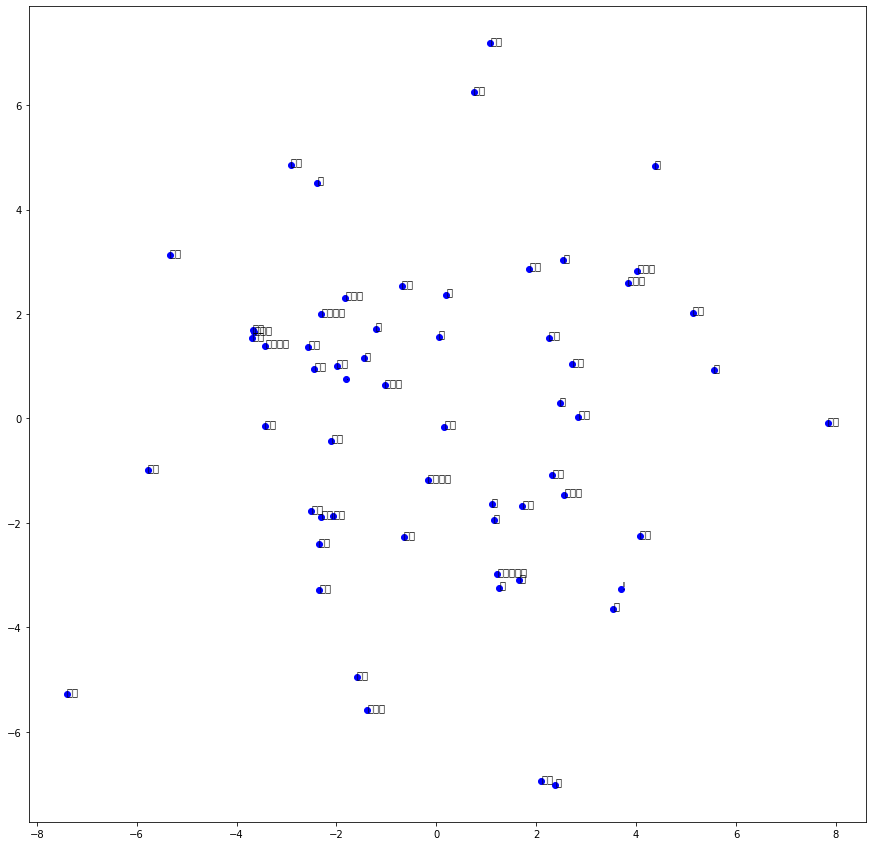

In [75]:
plt.figure(figsize=(15,15))

for word_id,(x_coordinate,y_coordinate) in enumerate(pc_weight):
  plt.scatter(x_coordinate,y_coordinate,color="blue")
  plt.annotate(i2w[word_id], (x_coordinate, y_coordinate))